# Convolution Neural Network Homework2

In this homework, we are going to practice:
1. How to preprocess and load data in pytorch
2. How to build a CNN model for training
3. Training/Validation Process and plot the result.
4. Using pretrained model.

<p align="center">
<img src="https://miro.medium.com/max/895/1*RjZe7cfnhdRhhLimLvapow.png" width="800">
</p>

## 0.1 Preparation

In [3]:
import os
import csv
import torch
import numpy as np
import pandas as pd

from PIL import Image
from google.colab import drive

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Use device:",device)

Use device: cuda:0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##############################################
# Decide your work and save path
##############################################
DataPath = '/content/homework2/'
SavePath = '/content/drive/MyDrive/Colab Notebooks/homework2/'

os.makedirs(DataPath, exist_ok = True)
os.makedirs(SavePath, exist_ok = True)

## 0.2 Download DataSet: 10 class creature dataset

<p align="center">
<img src="https://www.mirrormedia.com.tw/assets/images/20210811183042-492063c52c4c70e0ffe94db30f8395b8-mobile.jpg" width="400">
</p>

### Method 1: using origin gdown to download the id file

In [ ]:
if not os.path.isdir(os.path.join(DataPath, 'train_dataset/')):
    !pip install --upgrade --no-cache-dir gdown
    !gdown --id 1HguaSxM4tMCGU0VjmWW0cCzf3EhoaOWr --output 'dataset.zip'
    !unzip -q dataset.zip -d '/content/homework2' # the -d should be the same as DataPath

else:
    print("File already exists.")

### Method2: Download from link to unzip

1. Download File from the link: https://drive.google.com/uc?id=1HguaSxM4tMCGU0VjmWW0cCzf3EhoaOWr 
2. Upload to your google drive
3. Your path way of the zip : `'./drive/MyDrive/[where you put in your drive])`
3. unzip to your current workplace

In [ ]:
# There is a space between 'homework2_Dataset' and '.zip'
# -q: quiet mode
# -d: should be the same as DataPath
!unzip -q './drive/MyDrive/homework2_Dataset .zip' -d '/content/homework2'

# 1 Data Preprocess

## 1.1 Check on homework2 data

In [21]:
import pandas as pd

df = pd.read_csv(os.path.join(DataPath, 'train.csv'))
df.describe()

,img,label
count,20938,20938
unique,20938,10
top,0.jpg,dog
freq,1,3890


In [10]:
print(len(os.listdir('/content/homework2/train_dataset')))
print(len(os.listdir('/content/homework2/test_dataset')))

20938
5241


In [11]:
print(df['label'].value_counts())

dog          3890
spider       3856
chicken      2478
horse        2098
butterfly    1689
cow          1492
squirrel     1489
sheep        1456
cat          1334
elephant     1156
Name: label, dtype: int64


In [12]:
sorted(df['label'].value_counts().index)

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [22]:
Class = {}
for idx, label in enumerate(sorted(df['label'].value_counts().index)):
    Class[label] = idx
Class

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [14]:
df.iloc[20000]

img      20000.jpg
label     squirrel
Name: 20000, dtype: object

## 1.2 Pytorch Dataset & Dataloaders

### 1.2.1 torchvision.transforms *

In [6]:
##############################################
# Image preprocess and data augmentation
#
# Hint:
#   Resize input image first
#   you need to change image to tensor
#   Augmentation on train but not valid/test
##############################################

from torchvision import transforms

train_transform = transforms.Compose([
    # To Do
    ])
valid_transform = transforms.Compose([
    # To Do
    ])

### 1.2.2 torch.utils.data.Dataset *

In [7]:
##############################################
# Add dataset
##############################################
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self, xlist, ylist, transform = valid_transform):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        # To Do
        pass

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        # To Do
        pass

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        # To Do
        pass

In [ ]:
from sklearn.model_selection import train_test_split

imgpath = os.path.join(DataPath, 'train_dataset/')
csvpath = os.path.join(DataPath, 'train.csv')

df = pd.read_csv(csvpath)
xlist = (imgpath + df['img'].astype(str)).tolist()
ylist = df['label'].astype('category').cat.codes.tolist()

xtrain, xvalid, ytrain, yvalid = train_test_split(xlist, ylist, test_size=0.3, random_state=42)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.5, random_state=21)

trainset = dataset(xtrain, ytrain, train_transform)
validset = dataset(xvalid, yvalid, valid_transform)
testset = dataset(xtest, ytest, valid_transform)

print(f'trainset: {len(trainset)}\nvalidset: {len(validset)}\ntestset: {len(testset)}')

idx = np.random.randint(len(trainset))
print(f'{idx:5d}/{len(trainset)} : {trainset[idx]}')

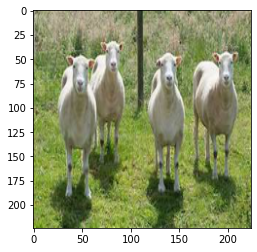

In [44]:
# Display the transform result

import matplotlib.pyplot as plt

idx = np.random.randint(len(trainset))
plt.imshow(trainset[idx][0].permute(1, 2, 0))

### 1.2.3 torch.utils.data.DataLoader *

In [10]:
# Loaded Datasets to DataLoaders

# batch_size also affect training step.
# higher: faster, stable
#   but inprecise on optimize, may use large memory
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers = 2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = 2)

# 2 Training module

In [11]:
from tqdm.notebook import tqdm

def train(model, trainloader, optimizer, criterion):
    # keep track of training loss
    train_loss = 0.0
    train_correct = 0
    
    # train the model 
    model.train()
    for data, target in tqdm(trainloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # update training Accuracy
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()

    return train_loss/len(trainloader.dataset), train_correct/len(trainloader.dataset)

In [12]:
@torch.no_grad()
def test(model, testloader, criterion):
    # keep track of validation loss
    valid_loss = 0.0
    valid_correct = 0

    # evaluate the model 
    model.eval()
    for data, target in tqdm(testloader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()

    return valid_loss/len(testloader.dataset), valid_correct/len(testloader.dataset)

In [13]:
def modeltrain(model, trainloader, validloader, testloader, optimizer, criterion, epochs, save_model_path, earlystop=4):
    history = {
        'trainloss' : [],
        'trainacc' : [],
        'validloss' : [],
        'validacc' : [],
    }
    state = {
        'epoch' : 0,
        'state_dict' : model.state_dict(),
        'trainloss' : 10000,
        'trainacc' : 0,
        'validloss' : 10000,
        'validacc' : 0,
    }
    valid_loss_min = 10000
    trigger = 0
    for epoch in range(epochs):
        print(f'running epoch: {epoch+1}')
        trainloss, trainacc = train(model, trainloader, optimizer, criterion)
        validloss, validacc = test(model, validloader, criterion)

        # print training/validation statistics 
        history['trainloss'].append(trainloss)
        history['trainacc'].append(trainacc)
        history['validloss'].append(validloss)
        history['validacc'].append(validacc)
        print(f'Training Loss  : {trainloss:.4f}\t\tTraining Accuracy  : {trainacc:.4f}')
        print(f'Validation Loss: {validloss:.4f}\t\tValidation Accuracy: {validacc:.4f}')
        
        # save model if validation loss has decreased
        if validloss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.4f} --> {validloss:.4f}).  Saving model ...\n')
            state['epoch'] = epoch
            state['state_dict'] = model.state_dict()
            state['trainloss'] = trainloss
            state['trainacc'] = trainacc
            state['validloss'] = validloss
            state['validacc'] = validacc

            torch.save(state, save_model_path)
            valid_loss_min = validloss
            trigger = 0
        # if model dont improve for 5 times, interupt.
        else:
            trigger += 1
            print(f'Validation loss increased ({valid_loss_min:.4f} --> {validloss:.4f}). Trigger {trigger}/{earlystop}\n')
            if trigger == earlystop:
                break
    print('\nTest Evaluate:')
    testloss, testacc = test(model, testloader, criterion)
    state['testloss'] = testloss
    state['testacc'] = testacc
    torch.save(state, save_model_path)
    bestepoch = state['epoch']
    validloss = state['validloss']
    validacc = state['validacc']
    print(f'Best model on epoch : {bestepoch}/{epoch}')
    print(f'validation loss: {validloss:.4f}\t\t validation acc : {validacc:.4f}')
    print(f'test loss      : {testloss:.4f}\t\t test acc \t: {testacc:.4f}')
    return history

# 3 CNN Model Training

In [22]:
SavePathModel = os.path.join(SavePath, 'model_exp')
os.makedirs(SavePathModel, exist_ok=True)

## 3.1 Build Better Network? *

### Layer
- Adjustment of convolution/pooling layer
- [Activation Layer](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
- Global [Average](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)/[Max](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html#torch.nn.AdaptiveMaxPool2d) Pooling

### Training Robustness
- [Augmentation](https://pytorch.org/vision/stable/transforms.html)
- [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [Dropout Layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)

In [ ]:
##############################################
# Build your model here!
# 
# Practice:
#   Improve your own Model!
##############################################

class trainmodel(nn.Module):
    def __init__(self):
        super(trainmodel, self).__init__()
        # To Do
        pass

    def forward(self, x):
        # To Do
        pass

model = trainmodel()
model.to(device)

## 3.2 Set Hyperparameter *
### Optimizer: attempt to find global minimum
- [SGD with momentum](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)

### Learning Rate Sceduler
- [Cosine Annealing Learning Rate](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

In [ ]:
##############################################
# Set Hyperparameter
# 
# Hint:
#   you can try different criterion loss, optimizer
##############################################

import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
n_epochs = 2
save_model_path = os.path.join(SavePathModel, 'model_weight.pth')

## 3.3 Start Training!

In [ ]:
history = modeltrain(
        model = model,
        trainloader = trainloader,
        validloader = validloader,
        testloader = testloader,
        optimizer = optimizer,
        criterion = criterion,
        epochs = n_epochs,
        save_model_path = save_model_path
        )

## 3.4 Plot the result

In [ ]:
import json
save_history = json.dumps(history)
with open(os.path.join(SavePathModel, 'history.json'), 'w') as f:
    json.dump(save_history, f)

In [31]:
import matplotlib.pyplot as plt

def plot(name, savedir, trainhistory, validhistory):
    plt.figure(figsize=(10,5))
    plt.plot(trainhistory, label = 'train')
    plt.plot(validhistory,  label = 'valid')
    plt.title(name)
    plt.xlabel("epochs")
    plt.show()
    plt.savefig(savedir)

In [ ]:
plot('Training Loss', os.path.join(SavePathModel,'loss.png'), history['trainloss'], history['validloss'])

In [ ]:
plot('Training Accuracy', os.path.join(SavePathModel,'acc.png'), history['trainacc'], history['validacc'])

## 3.5 load weight

In [ ]:
## create model as same as your training 
model = trainmodel()
model.to(device)

## load weight
state = torch.load(save_model_path)
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

## 3.6 test and save result

In [24]:
# If needed, Edit to make fit your situation

transform = transforms.Compose([
       transforms.Resize((224, 224)),
       transforms.ToTensor(),
])

class test_set(Dataset):
    def __init__(self, img_path, csv_path, transform = transform):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = os.path.join(self.img_path, self.df.iloc[index, 0])
        img = Image.open(imgpath)
        img = self.transform(img)

        return img, index
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.df)

In [ ]:
import torch.nn.functional as F

#load test data
testing_path = os.path.join(DataPath, 'test_dataset')
testcsv_path = os.path.join(DataPath, 'test.csv')

df = pd.read_csv(testcsv_path)

inv_Class = dict((v, k) for k, v in Class.items())

print(len(df))

testset = test_set(testing_path, testcsv_path)
testloader = DataLoader(testset, batch_size=1, shuffle=False,pin_memory=True,num_workers = 2)

model.eval()
with torch.no_grad():
    for data, idx in tqdm(testloader):
        data = data.to(device)
        pred = F.softmax(model(data),dim=1)
        pred = np.argmax(pred.detach().cpu().numpy(),axis=1)

        df.at[idx, 'label'] = inv_Class[int(pred)] # convert predicted integer back to class string, only works when batch = 1

df.head()
df.to_csv(os.path.join(SavePathModel, 'test_model.csv'), encoding='utf-8')

# 4 Pretrained Model Finetune

[Transfer Learning](https://hackmd.io/@allen108108/H1MFrV9WH)

[Transfer learning for computer vision tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Models and pre-trained weights](https://pytorch.org/vision/stable/models.html)

<p align="center">
<img src="https://miro.medium.com/max/1400/1*Ww3AMxZeoiB84GVSRBr4Bw.png" width="700">
</p>

In [14]:
SavePathPretrain = os.path.join(SavePath, 'pretrain_exp')
os.makedirs(SavePathPretrain, exist_ok=True)

## 4.1 Call Pretrained weight *

**WARNINGS** Maybe Freeze some layer would be good for finetune
> [Which layers should I freeze for fine tuning a resnet model on keras?](https://stackoverflow.com/questions/47206714/which-layers-should-i-freeze-for-fine-tuning-a-resnet-model-on-keras)
>
> [How the pytorch freeze network in some layers, only the rest of the training?](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088)

In [ ]:
##############################################
# Set Pretrained model for finetune
# 
# Hint:
#   you can try different model!
#   resnet18 is just an example
#   
#   Remember to change the output size to match our trainingset label
#
#   If neccesary, freeze some layer
##############################################
import torchvision.models as models

# resnet18 as example
finetune_model = models.resnet18(pretrained=True)

# Remember to change the output size to match our trainingset label
# Hint: Print out the model and assign new size to the model output.
# To Do

## 4.2 Set Hyperparameter *
### Optimizer: attempt to find global minimum
- [SGD with momentum](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)

### Learning Rate Sceduler
- [Cosine Annealing Learning Rate](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

In [16]:
##############################################
# Set Hyperparameter
# 
# Hint:
#   you can try different criterion loss, optimizer
##############################################

import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=finetune_model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
n_epochs = 1
save_fintune_path = os.path.join(SavePathPretrain, 'model_weight.pth')

## 4.3 Training Process

In [ ]:
history_fintune = modeltrain(
        model = finetune_model,
        trainloader = trainloader,
        validloader = validloader,
        testloader = testloader,
        optimizer = optimizer,
        criterion = criterion,
        epochs = n_epochs,
        save_model_path = save_fintune_path
        )

## 4.4 Plot the result

In [18]:
import json
save_history = json.dumps(history_fintune)
with open(os.path.join(SavePathPretrain, 'history_fintuned.json'), 'w') as f:
    json.dump(save_history, f)

In [ ]:
plot('Training Loss', os.path.join(SavePathPretrain,'loss.png'), history_fintune['trainloss'], history_fintune['validloss'])

In [ ]:
plot('Training Accuracy', os.path.join(SavePathPretrain,'acc.png'), history_fintune['trainacc'], history_fintune['validacc'])

## 4.5 load weight *

In [ ]:
## Should be the same as your pretrained model type
finetune_model = models.resnet18(pretrained=False)
# To Do

## load weight
state = torch.load(save_fintune_path)
finetune_model.load_state_dict(state['state_dict'])

## 4.6 test and save result

In [ ]:
import torch.nn.functional as F
#load test data
testing_path = os.path.join(DataPath, 'test_dataset')
testcsv_path = os.path.join(DataPath, 'test.csv')

df = pd.read_csv(testcsv_path)

inv_Class = dict((v, k) for k, v in Class.items())

print(len(df))

testset = test_set(testing_path, testcsv_path)
testloader = DataLoader(testset, batch_size=1, shuffle=False,pin_memory=True,num_workers = 2)

finetune_model.eval()
with torch.no_grad():
    for data, idx in tqdm(testloader):
        data = data.to(device)
        pred = F.softmax(finetune_model(data),dim=1)
        pred = np.argmax(pred.detach().cpu().numpy(),axis=1)
        df.at[idx, 'label'] = inv_Class[int(pred)] # convert predicted integer back to class string, only works when batch = 1

df.head()
df.to_csv(os.path.join(SavePathPretrain, 'test_pretrain.csv'), encoding='utf-8')